In [8]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import h5py
import os
from math import pi

from analysis.config import birds, h5_path_dict, pickle_dir
from analysis.ExpData import ExpData
from analysis.utils import popln_overlap, get_fr

In [10]:
def get_site_distance(a, b):
    dist = min(
        abs(a - b), 16 - abs(a-b)
        ) % 16
    return dist

In [55]:
save_dir = pickle_dir/"reactivation_pairs"
visit_types = [
    "cache", "retriev", "checkfull",
    "navfull", "checkempty", "navempty"
    ]
visit_types_titles = [
    "Cache", "Retrieval", "Check Full",
    "Nav. Full", "Check Empty", "Nav. Empty"
    ]

## Make reactivation distribution table

In [45]:
table = np.zeros((9, 6, 6))

In [85]:
for i, type_i in enumerate(visit_types):
    for j, type_j in enumerate(visit_types):
        pk_file_ij = save_dir / f"{type_i}_{type_j}.p"
        pk_file_ji = save_dir / f"{type_j}_{type_i}.p"
        if not os.path.isfile(pk_file_ij) and not os.path.isfile(pk_file_ji):
            continue
        elif os.path.isfile(pk_file_ij):
            pk_file = pk_file_ij
        else:
            pk_file = pk_file_ji
        with open(pk_file, "rb") as f:
            distance_matrix = np.array(pickle.load(f))
        vals_by_sitedist = [[] for _ in range(9)]
        for ii in range(distance_matrix.shape[0]):
            for jj in range(distance_matrix.shape[1]):
                mat_ij = np.array(distance_matrix[ii,jj])
                nonnan_vals = mat_ij[np.logical_not(np.isnan(mat_ij))].tolist()
                dist = get_site_distance(ii,jj)
                vals_by_sitedist[dist].extend(nonnan_vals)
        for dist in np.arange(9):
            val = np.nanmedian(vals_by_sitedist[dist])
            all_vals = np.array(vals_by_sitedist[dist])
            val = np.sum(all_vals > 0.5)/all_vals.size
            table[dist][i][j] = val
            table[dist][j][i] = val

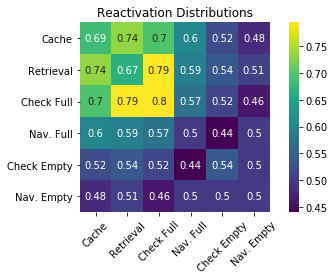

In [86]:
sns.heatmap(
    table[0], annot=True, cmap="viridis", square="True"
    )
plt.title("Reactivation Distributions")
plt.xticks(np.arange(6)+0.5, visit_types_titles, rotation=45)
plt.yticks(np.arange(6)+0.5, visit_types_titles, rotation=0)
plt.tight_layout()
plt.savefig("reactivation_table.png", dpi=200)
plt.show()

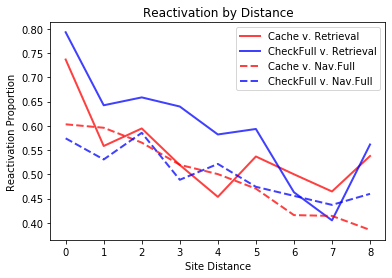

In [87]:
plt.figure()
cache = 0; retrieval = 1; checkfull = 2;
navfull = 3; checkempty=4; navempty=5;
plt.plot(
    table[:, cache, retrieval].T, "r-",
    label="Cache v. Retrieval", linewidth=2, alpha=0.75
    )
plt.plot(
    table[:, checkfull, retrieval].T, "b-",
    label="CheckFull v. Retrieval", linewidth=2, alpha=0.75
    )
plt.plot(
    table[:, cache, navfull].T, "r--",
    label="Cache v. Nav.Full", linewidth=2, alpha=0.75
    )
plt.plot(
    table[:, checkfull, navfull].T, "b--",
    label="CheckFull v. Nav.Full", linewidth=2, alpha=0.75
    )
plt.title("Reactivation by Distance")
plt.xlabel("Site Distance")
plt.ylabel("Reactivation Proportion")
plt.legend()
plt.show()